### Import packages
---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install dgl

     |████████████████████████████████| 3.6MB 11.7MB/s 


In [3]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical   
from keras import layers as L
import keras as k

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")

import umap

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn.pytorch import GraphConv
import itertools
from sklearn import metrics as m

In [5]:
train = pd.read_pickle('drive/Shareddrives/MO434_final_project/Dataset/FINAL_DATASET/Train_FeatureVectors_Covid16_Classifier_Bag.pkl')
X_train = train.iloc[:, 44:].astype(float)
y_train = train['# class'].astype(int)

test = pd.read_pickle('drive/Shareddrives/MO434_final_project/Dataset/FINAL_DATASET/Test_FeatureVectors_Covid16_Classifier_Bag.pkl')
X_test = test.iloc[:, 44:].astype(float)
y_test = test['# class'].astype(int)

In [ ]:
# train = pd.read_pickle('../dataset/Train_FeatureVectors_Covid16_Classifier_Bag.pkl')
# X_train = train.iloc[:, 44:].astype(float)
# y_train = train['# class'].astype(int)

# test = pd.read_pickle('../dataset/Test_FeatureVectors_Covid16_Classifier_Bag.pkl')
# X_test = test.iloc[:, 44:].astype(float)
# y_test = test['# class'].astype(int)

### Open dataset and arrange data
---

In [ ]:
def bag_of_signal(mz_dataset, intensity_dataset, feature_vector_size=40000):
  
  # Gets all unique mz values into the dataset
  list_unique_mz, counts = np.unique(
      np.concatenate(mz_dataset, axis=0),
      return_counts=True)
  
  # Sort mz counts args in descending (largest to smallest) order
  # In other words, arrenge to the most frequenty to less
  mz_descending_order = np.flip(np.argsort(counts))

  # Get the n most frequenty args
  n_most_freq = mz_descending_order[0: feature_vector_size]

  # Draw the dictionary header, get MZs
  mz_dict_header = [list_unique_mz[i] for i in n_most_freq]

  feature_vectors = []

  # For each mz molecules in the dictionary
  for patient_mz, patient_intensity in tqdm(zip(mz_dataset, intensity_dataset),
                                            total=mz_dataset.shape[0]):

    patient_vector = []

    # For each mz value in the dictionary header
    for mz_value in mz_dict_header:

      # Check if the patient has that mz molecule
      if mz_value in patient_mz:

        # If yes, store their intensity value
        arg = np.argwhere(patient_mz == mz_value)        
        patient_vector.append(int(patient_intensity[arg]))

      else:

        # Otherwise, set as zero
        patient_vector.append(0)

    feature_vectors.append(patient_vector)
    
  final_feature_vector = pd.DataFrame(feature_vectors, 
                                      columns=mz_dict_header)
  
  # Return the final bag of signal values for each patient
  return final_feature_vector
  
# vector = bag_of_signal(d.mz, d.intensity, feature_vector_size=3934)

In [ ]:
def truncate_vector(mz_dataset, intensity_dataset):

  # Define the max length of the feature vector
  max = 0
  for mz in d.mz:
    if (mz.shape[0] > max):
      max = mz.shape[0]

  new_mz_dataset = []
  new_intensity_dataset = []

  # Truncate feature vectors
  for mz, intensity in zip(mz_dataset, intensity_dataset):
    tmp_len = mz.shape[0]
    tmp_mz = mz + [0] * (max - tmp_len)
    tmp_intensity = intensity + [0] * (max - tmp_len)

    new_mz_dataset.append(tmp_mz)
    new_intensity_dataset.append(tmp_intensity)
  
  return new_mz_dataset, new_intensity_dataset


In [ ]:
# d = pd.read_csv('drive/Shareddrives/Deep Learning/Projeto Final/Dataset/FINAL_DATASET/FeatureVectors_Matrix_Covid16_Classifier_Bag.csv')
# header = d.iloc[:, 0]
# tmp_d = d.drop(columns=d.columns[[0]])
# t = tmp_d.T
# new_dataset = t.set_axis(header, axis=1, inplace=False)

# dataset = pd.read_pickle('drive/Shareddrives/Deep Learning/Projeto Final/Dataset/FINAL_DATASET/FeatureVectors_Matrix_Covid16_Classifier_Bag.pkl')

In [ ]:
def split_list(list_to_split, size=0.60):

  l1 = random.sample(list_to_split, round(len(list_to_split) * size))
  l2 = np.setdiff1d(list_to_split, l1)

  return l1, l2

# n_ctg = np.unique(dataset['# ctg number'])
# n_pat = np.unique(dataset['# idv number'])

In [ ]:
def split_dataset_by_severity():

  pat_train = []
  pat_test = []

  for ctg in n_ctg:

    pat_ctg = np.unique(dataset['# idv number'][dataset['# ctg number'] == ctg])

    train, test = split_list(list(pat_ctg))
    pat_train.extend(train)
    pat_test.extend(test)
    X_train = dataset[dataset['# idv number'].isin(pat_train)]

  X_test = dataset[dataset['# idv number'].isin(pat_test)]

  X_train.to_pickle('drive/Shareddrives/Deep Learning/Projeto Final/Dataset/FINAL_DATASET/Train_FeatureVectors_Covid16_Classifier_Bag.pkl')
  X_test.to_pickle('drive/Shareddrives/Deep Learning/Projeto Final/Dataset/FINAL_DATASET/Test_FeatureVectors_Covid16_Classifier_Bag.pkl')
  

### Util functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title):

  plt.rcParams['figure.figsize'] = [6,6]
  plt.rcParams['figure.dpi'] = 80

  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  ax = plt.subplot()

  sns.heatmap(cm, annot=True, cmap="Blues", ax = ax, cbar=False)
  
  if len(labels) == 2:
    
    ax.xaxis.set_ticklabels([labels[0], labels[1]]) 
    ax.yaxis.set_ticklabels([labels[0], labels[1]])
  
  else:

    ax.xaxis.set_ticklabels([labels[0], labels[1], labels[2]]) 
    ax.yaxis.set_ticklabels([labels[0], labels[1], labels[2]])

  ax.set_title(title)

  plt.show()

In [ ]:
def plot_importance(cancelOut_importances, n, feature_names):

  plt.rcParams['figure.figsize'] = [10,10]
  plt.rcParams['figure.dpi'] = 150

  plt.title('Gráfico importância')

  indices = np.flip(np.argsort(cancelOut_importances))[:n]
  plt.barh(range(len(indices)), cancelOut_importances[indices], color='g', align='center')

  plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
  plt.xlabel('Importância relativa das massas')

  plt.show()

  return indices

In [6]:
def normalize_dataset_by_sample(X):

  row_max = np.max(X)
  new_X = X / row_max

  return new_X

# norm_X_train = X_train.apply(normalize_dataset_by_sample, axis=1)

In [7]:
def to_multiclass(y, X=None, drop=False):

  if drop:

    index = y[y >= 12].index
    y.drop(index, inplace=True)
    X.drop(index, inplace=True)
    X = X.apply(normalize_dataset_by_sample)

  y[y <= 5 ] = 0 # Grave
  mask = (y > 5) & (y < 12) # Não Grave
  y = y.mask(mask, 1)
  y[y >= 12 ] = 2 # Controle

  return X, to_categorical(y, 2)

In [8]:
def plot_results(history):
  
  plt.rcParams['figure.figsize'] = [12, 16]
  plt.rcParams['figure.dpi'] = 100

  ax1 = plt.subplot(4, 2, 1)
  ax2 = plt.subplot(4, 2, 2)
  ax3 = plt.subplot(4, 2, 3)
  ax4 = plt.subplot(4, 2, 4)
  ax5 = plt.subplot(4, 2, 5)
  ax6 = plt.subplot(4, 2, 6)
  ax7 = plt.subplot(4, 2, 7)
  ax8 = plt.subplot(4, 2, 8)

  for label, hist in history.items():
    ax1.plot(range(len(hist.loss)), hist.loss, label=label)
    ax3.plot(range(len(hist.loss)), hist.binary_accuracy, label=label)
    ax5.plot(range(len(hist.loss)), hist.iloc[:, 3], label=label)
    ax7.plot(range(len(hist.loss)), hist.iloc[:, 4], label=label)
    ax2.plot(range(len(hist.loss)), hist.val_loss, label=label)
    ax4.plot(range(len(hist.loss)), hist.val_binary_accuracy, label=label)
    ax6.plot(range(len(hist.loss)), hist.iloc[:, -1], label=label)
    ax8.plot(range(len(hist.loss)), hist.iloc[:, -2], label=label)

  ax1.set_title(f'Training Loss')
  ax3.set_title(f'Training Accuracy')
  ax5.set_title(f'Training AUC')
  ax7.set_title(f'Training Recall')
  ax2.set_title(f'Validation Loss')
  ax4.set_title(f'Validation Accuracy')
  ax6.set_title(f'Validation AUC')
  ax8.set_title(f'Validation Recall')
  ax1.legend()
  ax2.legend()
  ax3.legend()
  ax4.legend()
  ax5.legend()
  ax6.legend()
  ax7.legend()
  ax8.legend()
  plt.show()

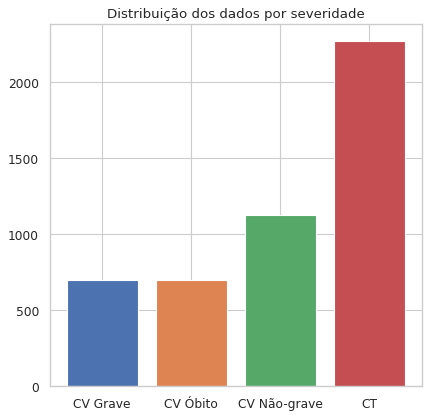

In [ ]:
def plot_dataset_distribution(dataset):

  plt.rcParams['figure.figsize'] = [6,6]
  plt.rcParams['figure.dpi'] = 80

  ctg = np.unique(dataset['# category'], return_counts=True)

  # Sim eu poderia ter feito isso com expressões regulares para deixar o código limpo, mas...
  g = [0, 2,4,7]
  o = [1,3,5]
  n_g = [6,8, 9, 10, 11]
  neg = [12,13,14,15,16,17,18]
  cases = [g, o, n_g, neg]

  names=['CV Grave', 'CV Óbito', 'CV Não-grave', 'CT']
  counts = []

  for case in cases:
    sum = 0
    for i in case:
      sum += ctg[1][i]
    counts.append(sum)


  c = [sns.color_palette()[x] for x in range(len(counts))]
  plt.bar(names, counts, color=c, )
  plt.title('Distribuição dos dados por severidade')

plot_dataset_distribution(train)

### CancelOut

----

In this approach we try to find what are the most relevante ions in order to use these are seeds for the next experiments.

In [ ]:
# We have used this repository as reference
# https://github.com/unnir/CancelOut/blob/master/keras_example.ipynb

class CancelOut(L.Layer):

  def __init__(self, activation, use_loss=True, first_lamb=0.002, sec_lamb=0.001):

    super(CancelOut, self).__init__()


    self.activation = activation
    self.use_loss = use_loss
    self.first_lamb = first_lamb
    self.sec_lamb = sec_lamb

  def build(self, input_shape):

    self.w = self.add_weight(
                             shape=(input_shape[-1],),
                             initializer=k.initializers.Constant(1),
                             trainable=True)

  def call(self, inputs):

    if self.use_loss:
      self.add_loss(
                    self.first_lamb * tf.norm(self.w, ord=1) + 
                    self.sec_lamb * tf.norm(self.w, ord=2)
                    )
    return tf.math.multiply(inputs, self.activation(self.w))
      
  def get_config(self):
    return {'activation':self.activation}

## Neural Network models
---

In this section we build some neural networks architectures to understand data behavior. We believe that convolutional topologies will not work for this problem since the ...

In [9]:
# Defining some hiper parameters
EPOCHS = 100

# Binary to categorical label
y_train_categ = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_categ = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Normalize dataset 
X_train_norm = X_train.apply(normalize_dataset_by_sample)
X_test_norm = X_test.apply(normalize_dataset_by_sample)

print(X_train.shape, X_train_norm.shape)

(4796, 3934) (4796, 3934)


### Conv Neural Network
---

In [ ]:
def CovConvNet(input_shape):

    initializer = k.initializers.GlorotUniform(seed=2389)
    regularizer = k.regularizers.l1_l2()
    optimizer = k.optimizers.SGD(learning_rate=1e-4)

    inputs = k.Input(shape=input_shape)

    conv1 = L.Conv1D(filters=40, kernel_size=10, activation='relu')(inputs)
    drop1 = L.Dropout(0.5)(conv1)
                           
    conv2 = L.Conv1D(filters=40, kernel_size=10, activation='relu')(drop1)
    drop2 = L.Dropout(0.5)(conv2)
                           
    conv3 = L.Conv1D(filters=40, kernel_size=10, activation='relu')(drop2)
    drop3 = L.Dropout(0.5)(conv3)

    flatten = L.Flatten()(drop3)

    dense1 = L.Dense(400, activation="relu")(flatten)
    drop4 = L.Dropout(0.5)(dense1)
    output = L.Dense(2, activation="softmax")(drop4)

    model = k.Model(inputs=[inputs], outputs=output)
    model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=[k.metrics.BinaryAccuracy(), 
                                k.metrics.Precision(), 
                                k.metrics.Recall(),
                                k.metrics.AUC()])

    return model

In [ ]:
# Arrange dataset to input CovConvNet

X_train_conv = X_train_norm.to_numpy()
X_train_conv = X_train_conv.reshape((X_train_conv.shape[0], X_train_conv.shape[1], 1))
input_shape = (X_train_conv.shape[1], 1) # (3934, 1)

In [ ]:
model = CovConvNet(input_shape)
history = model.fit(x=X_train_conv, y=y_train_categ, validation_data=(X_test_norm, y_test_categ), epochs=EPOCHS)

Epoch 1/100
150/150 [==============================] - 7s 44ms/step - loss: 0.6933 - binary_accuracy: 0.4996 - precision: 0.4996 - recall: 0.4996 - auc: 0.5063 - val_loss: 0.6920 - val_binary_accuracy: 0.5287 - val_precision: 0.5287 - val_recall: 0.5287 - val_auc: 0.5375
Epoch 2/100
150/150 [==============================] - 6s 39ms/step - loss: 0.6896 - binary_accuracy: 0.5279 - precision: 0.5279 - recall: 0.5279 - auc: 0.5462 - val_loss: 0.6898 - val_binary_accuracy: 0.5274 - val_precision: 0.5274 - val_recall: 0.5274 - val_auc: 0.5658
Epoch 3/100
150/150 [==============================] - 6s 39ms/step - loss: 0.6874 - binary_accuracy: 0.5321 - precision: 0.5321 - recall: 0.5321 - auc: 0.5633 - val_loss: 0.6880 - val_binary_accuracy: 0.5268 - val_precision: 0.5268 - val_recall: 0.5268 - val_auc: 0.5904
Epoch 4/100
150/150 [==============================] - 6s 38ms/step - loss: 0.6864 - binary_accuracy: 0.5377 - precision: 0.5377 - recall: 0.5377 - auc: 0.5710 - val_loss: 0.6865 - val

150/150 [==============================] - 6s 39ms/step - loss: 0.6527 - binary_accuracy: 0.6093 - precision: 0.6093 - recall: 0.6093 - auc: 0.6854 - val_loss: 0.6576 - val_binary_accuracy: 0.5870 - val_precision: 0.5870 - val_recall: 0.5870 - val_auc: 0.6990
Epoch 32/100
150/150 [==============================] - 6s 39ms/step - loss: 0.6523 - binary_accuracy: 0.6134 - precision: 0.6134 - recall: 0.6134 - auc: 0.6853 - val_loss: 0.6562 - val_binary_accuracy: 0.5923 - val_precision: 0.5923 - val_recall: 0.5923 - val_auc: 0.7007
Epoch 33/100
150/150 [==============================] - 6s 39ms/step - loss: 0.6514 - binary_accuracy: 0.6147 - precision: 0.6147 - recall: 0.6147 - auc: 0.6874 - val_loss: 0.6548 - val_binary_accuracy: 0.5976 - val_precision: 0.5976 - val_recall: 0.5976 - val_auc: 0.7022
Epoch 34/100
150/150 [==============================] - 6s 39ms/step - loss: 0.6494 - binary_accuracy: 0.6203 - precision: 0.6203 - recall: 0.6203 - auc: 0.6940 - val_loss: 0.6533 - val_binary_a

150/150 [==============================] - 6s 38ms/step - loss: 0.5809 - binary_accuracy: 0.7636 - precision: 0.7636 - recall: 0.7636 - auc: 0.8310 - val_loss: 0.5876 - val_binary_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 0.7266 - val_auc: 0.8109
Epoch 62/100
150/150 [==============================] - 6s 39ms/step - loss: 0.5755 - binary_accuracy: 0.7675 - precision: 0.7675 - recall: 0.7675 - auc: 0.8371 - val_loss: 0.5839 - val_binary_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 0.7297 - val_auc: 0.8168
Epoch 63/100
150/150 [==============================] - 6s 39ms/step - loss: 0.5729 - binary_accuracy: 0.7656 - precision: 0.7656 - recall: 0.7656 - auc: 0.8335 - val_loss: 0.5802 - val_binary_accuracy: 0.7369 - val_precision: 0.7369 - val_recall: 0.7369 - val_auc: 0.8210
Epoch 64/100
150/150 [==============================] - 6s 39ms/step - loss: 0.5685 - binary_accuracy: 0.7663 - precision: 0.7663 - recall: 0.7663 - auc: 0.8378 - val_loss: 0.5764 - val_binary_a

150/150 [==============================] - 6s 39ms/step - loss: 0.4497 - binary_accuracy: 0.8226 - precision: 0.8226 - recall: 0.8226 - auc: 0.8988 - val_loss: 0.4612 - val_binary_accuracy: 0.8236 - val_precision: 0.8236 - val_recall: 0.8236 - val_auc: 0.8896
Epoch 92/100
150/150 [==============================] - 6s 39ms/step - loss: 0.4477 - binary_accuracy: 0.8326 - precision: 0.8326 - recall: 0.8326 - auc: 0.9006 - val_loss: 0.4569 - val_binary_accuracy: 0.8261 - val_precision: 0.8261 - val_recall: 0.8261 - val_auc: 0.8915
Epoch 93/100
150/150 [==============================] - 6s 39ms/step - loss: 0.4418 - binary_accuracy: 0.8269 - precision: 0.8269 - recall: 0.8269 - auc: 0.9019 - val_loss: 0.4512 - val_binary_accuracy: 0.8301 - val_precision: 0.8301 - val_recall: 0.8301 - val_auc: 0.8952
Epoch 94/100
150/150 [==============================] - 6s 39ms/step - loss: 0.4323 - binary_accuracy: 0.8355 - precision: 0.8355 - recall: 0.8355 - auc: 0.9082 - val_loss: 0.4512 - val_binary_a

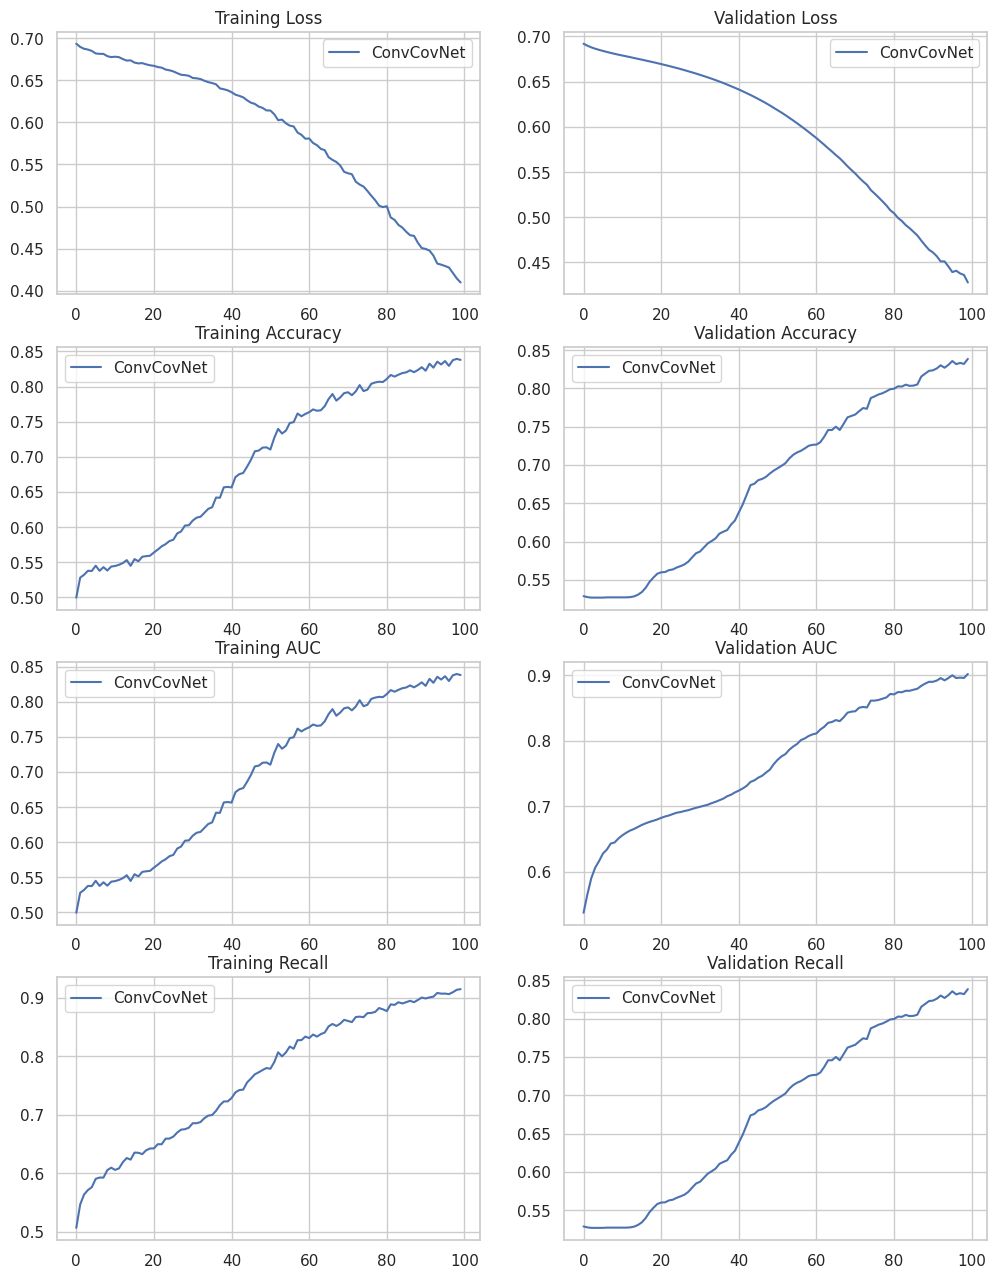

In [ ]:
conv_cov_net = {"ConvCovNet": pd.DataFrame.from_dict(history.history)}
plot_results(conv_cov_net)

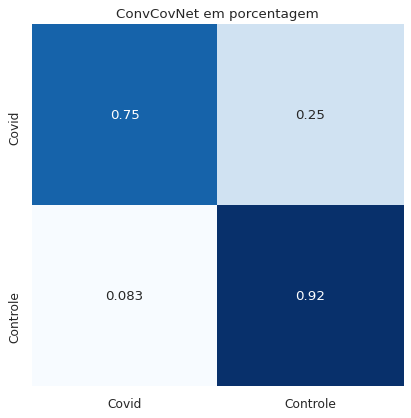

In [ ]:
y_pred = model.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)


plot_confusion_matrix(y_test, y_pred, ['Covid', 'Controle'], 'ConvCovNet em porcentagem')

### Recurrent Neural Network
---

In [ ]:
# Arrange dataset to input CovRnnNet

X_train_rnn = X_train_norm.to_numpy()
X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], X_train_rnn.shape[1], 1))
input_shape = (X_train_rnn.shape[1], 1) # (3934, 1)

In [ ]:
def CovRnnNet(input_shape):

  initializer = k.initializers.GlorotUniform(seed=2389)
  regularizer = k.regularizers.l1_l2()
  optimizer = k.optimizers.SGD(learning_rate=1e-3)

  inputs = k.Input(shape=input_shape)

  rnn = L.LSTM(100)(inputs)

  dense2 = L.Dense(32, activation="relu")(rnn)

  output = L.Dense(2, activation="softmax")(dense2)

  model = k.Model(inputs=[inputs], outputs=output)
  model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=[k.metrics.BinaryAccuracy(), 
                                k.metrics.Precision(), 
                                k.metrics.Recall(),
                                k.metrics.AUC()])

  return model

In [ ]:
model_1 = CovRnnNet(input_shape)

history_1 = model_1.fit(X_train_norm, y_train_categ, validation_data=(X_test_norm, y_test_categ), epochs=EPOCHS)

Epoch 1/100
150/150 [==============================] - 28s 174ms/step - loss: 0.6932 - binary_accuracy: 0.4956 - precision_1: 0.4952 - recall_1: 0.4927 - auc_1: 0.5016 - val_loss: 0.6926 - val_binary_accuracy: 0.5243 - val_precision_1: 0.5243 - val_recall_1: 0.5243 - val_auc_1: 0.5242
Epoch 2/100
150/150 [==============================] - 25s 165ms/step - loss: 0.6924 - binary_accuracy: 0.5309 - precision_1: 0.5309 - recall_1: 0.5309 - auc_1: 0.5364 - val_loss: 0.6920 - val_binary_accuracy: 0.5268 - val_precision_1: 0.5268 - val_recall_1: 0.5268 - val_auc_1: 0.5532
Epoch 3/100
150/150 [==============================] - 25s 166ms/step - loss: 0.6920 - binary_accuracy: 0.5270 - precision_1: 0.5270 - recall_1: 0.5270 - auc_1: 0.5408 - val_loss: 0.6917 - val_binary_accuracy: 0.5268 - val_precision_1: 0.5268 - val_recall_1: 0.5268 - val_auc_1: 0.5532
Epoch 4/100
150/150 [==============================] - 25s 165ms/step - loss: 0.6911 - binary_accuracy: 0.5355 - precision_1: 0.5355 - recall_

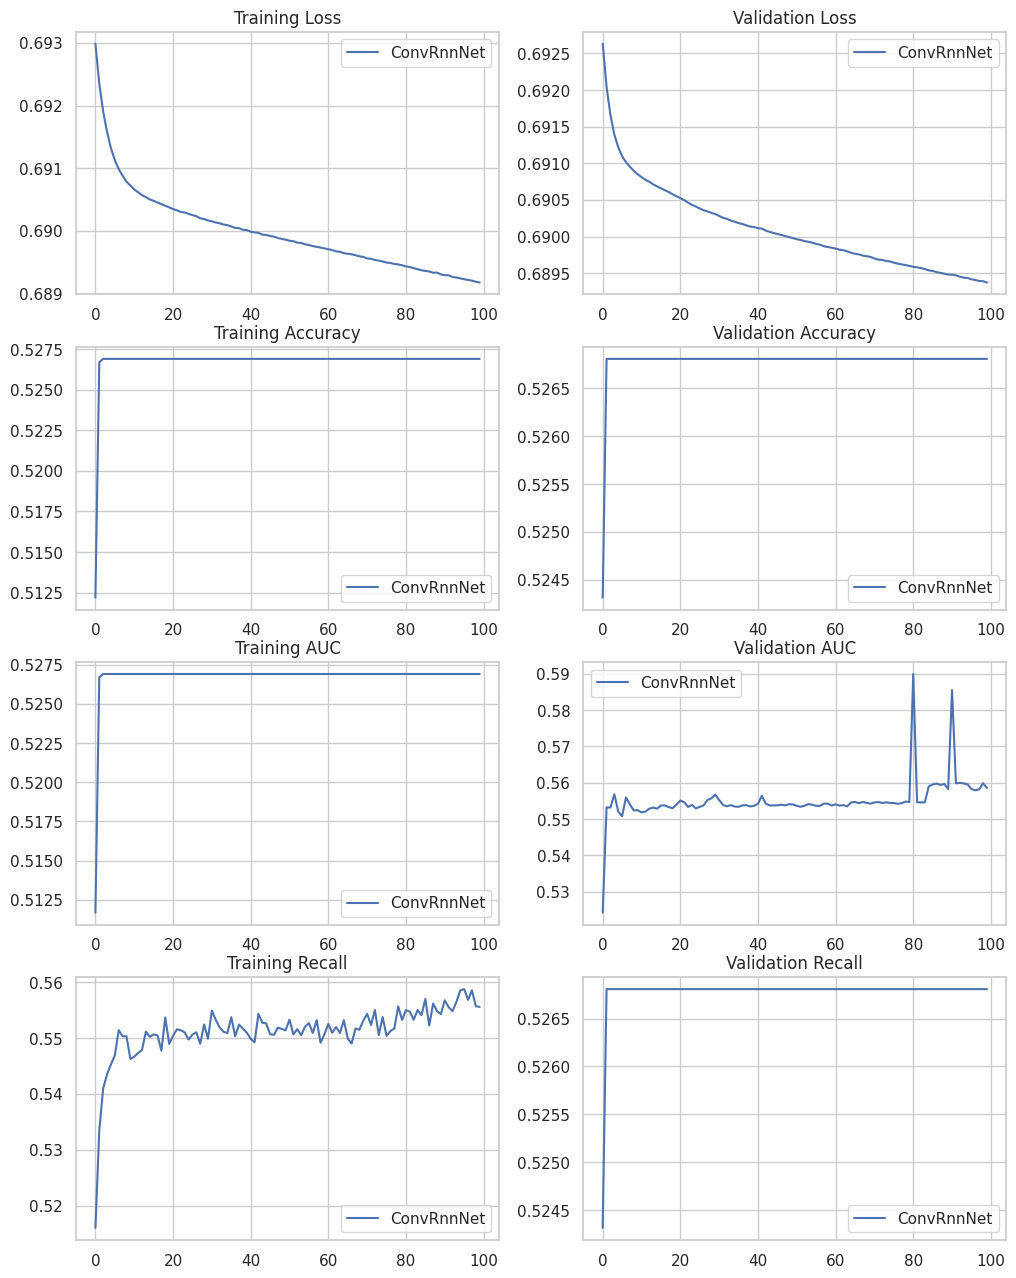

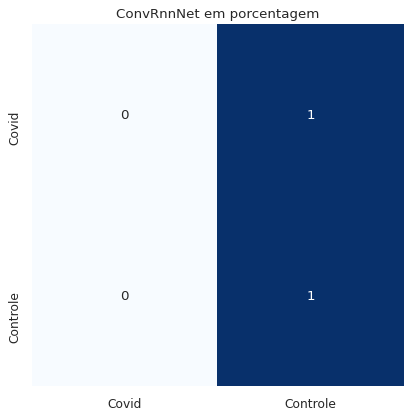

In [ ]:
conv_cov_net = {"ConvRnnNet": pd.DataFrame.from_dict(history_1.history)}
plot_results(conv_cov_net)

y_pred = model_1.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, ['Covid', 'Controle'], 'ConvRnnNet em porcentagem')

### Dense Neural Network
---

In [ ]:
def CovDenseNet(input_shape, n_classes=None):

  if n_classes == None:
    n_classes = 2

  initializer = k.initializers.GlorotUniform(seed=2389)
  regularizer = k.regularizers.l1_l2()
  optimizer = k.optimizers.SGD(learning_rate=1e-3)

  inputs = k.Input(shape=input_shape)

  dense1 = L.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=initializer)(inputs)
  dense2 = L.Dense(32, activation="relu", kernel_regularizer=regularizer, kernel_initializer=initializer)(dense1)

  output = L.Dense(n_classes, activation="softmax", kernel_regularizer=regularizer, kernel_initializer=initializer)(dense2)

  model = k.Model(inputs=[inputs], outputs=output)
  model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=[k.metrics.BinaryAccuracy(), 
                                k.metrics.Precision(), 
                                k.metrics.Recall(),
                                k.metrics.AUC()])

  return model

In [ ]:
input_shape = (X_train.shape[1], ) # (3934, )

model_2 = CovDenseNet(input_shape)

history_2 = model_2.fit(X_train_norm, y_train_categ, validation_data=(X_test_norm, y_test_categ), epochs=EPOCHS)

# model_2.save('drive/Shareddrives/MO434_final_project/Models/CovDenseNet')

Epoch 1/100
150/150 [==============================] - 3s 12ms/step - loss: 52.7433 - binary_accuracy: 0.5453 - precision_6: 0.5453 - recall_6: 0.5453 - auc_6: 0.6358 - val_loss: 49.6908 - val_binary_accuracy: 0.6446 - val_precision_6: 0.6446 - val_recall_6: 0.6446 - val_auc_6: 0.7417
Epoch 2/100
150/150 [==============================] - 1s 8ms/step - loss: 48.6911 - binary_accuracy: 0.7246 - precision_6: 0.7246 - recall_6: 0.7246 - auc_6: 0.8062 - val_loss: 45.7834 - val_binary_accuracy: 0.7475 - val_precision_6: 0.7475 - val_recall_6: 0.7475 - val_auc_6: 0.8431
Epoch 3/100
150/150 [==============================] - 1s 8ms/step - loss: 44.8260 - binary_accuracy: 0.8121 - precision_6: 0.8121 - recall_6: 0.8121 - auc_6: 0.8924 - val_loss: 42.0551 - val_binary_accuracy: 0.8024 - val_precision_6: 0.8024 - val_recall_6: 0.8024 - val_auc_6: 0.8879
Epoch 4/100
150/150 [==============================] - 1s 8ms/step - loss: 41.1400 - binary_accuracy: 0.8620 - precision_6: 0.8620 - recall_6: 0

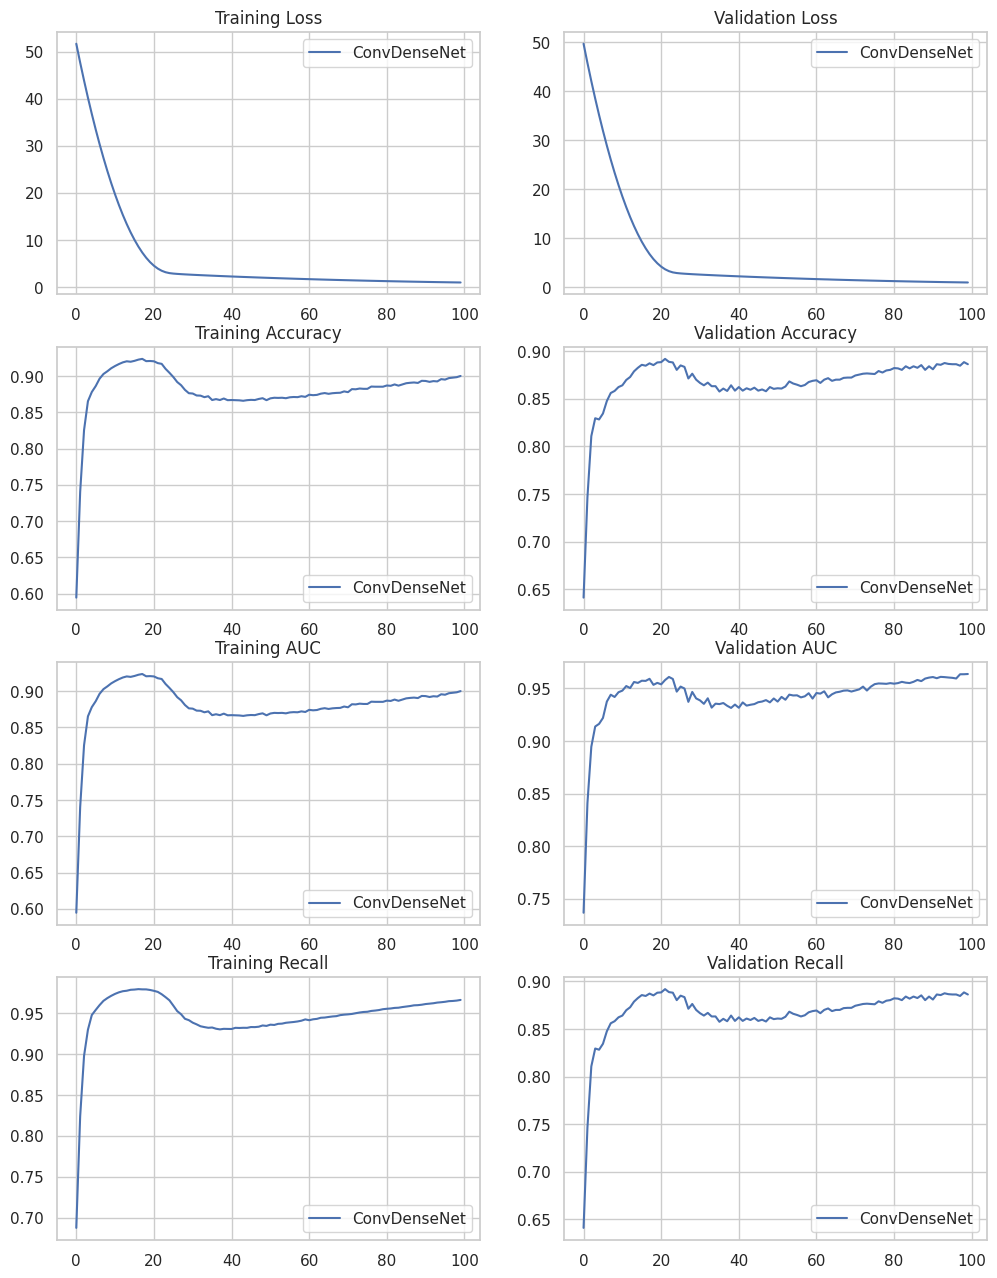

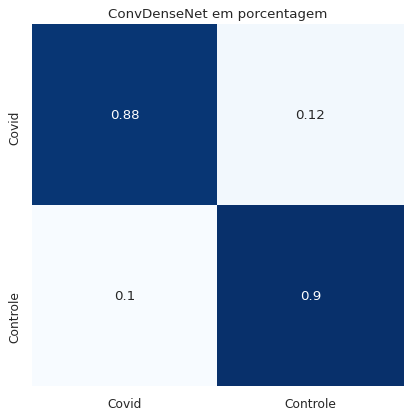

In [ ]:
conv_cov_net = {"ConvDenseNet": pd.DataFrame.from_dict(history_2.history)}
plot_results(conv_cov_net)

y_pred = model_2.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, ['Covid', 'Controle'], 'ConvDenseNet em porcentagem')

#### Plot UMAP

---

Here we want to understant the structure of the dataset since only the dense network works properly to classify the samples.

In [ ]:
umap_op = umap.UMAP()
data_umap = umap_op.fit_transform(X_test)

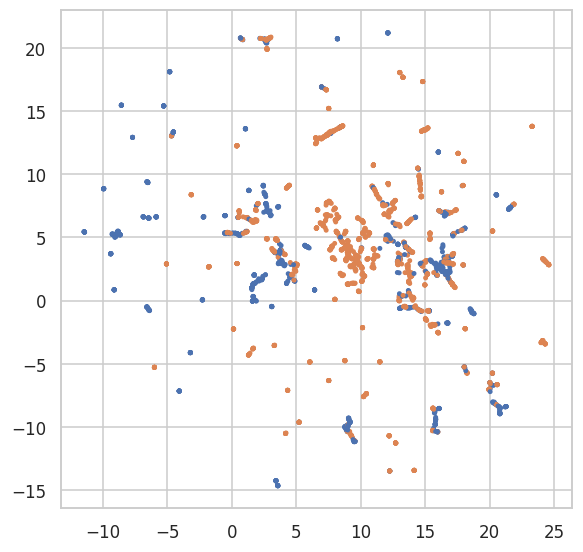

In [ ]:
plt.figure(num=None, figsize=(6,6), dpi=110, facecolor='w', edgecolor='k')
plt.scatter(data_umap[:,0], data_umap[:,1], 
            cmap="Spectral", s=5, 
            c=[sns.color_palette()[x] for x in y_pred])

### CancelOut
---

Here we want to identify the most relevant molecules which contribute most in the prediction part

In [ ]:
def CovDenseNet_CancelOut(input_shape):

  initializer = k.initializers.GlorotUniform(seed=2389)
  regularizer = k.regularizers.l1_l2()
  optimizer = k.optimizers.SGD(learning_rate=1e-3)

  inputs = k.Input(shape=input_shape)

  cancelOut_act = tf.sigmoid
  cancelOut = CancelOut(activation=cancelOut_act)(inputs)

  dense1 = L.Dense(64, activation="relu", kernel_regularizer=regularizer, kernel_initializer=initializer)(cancelOut)
  dense2 = L.Dense(32, activation="relu", kernel_regularizer=regularizer, kernel_initializer=initializer)(dense1)

  output = L.Dense(2, activation="softmax", kernel_regularizer=regularizer, kernel_initializer=initializer)(dense2)

  model = k.Model(inputs=[inputs], outputs=output)
  model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=[k.metrics.BinaryAccuracy(), 
                                k.metrics.Precision(), 
                                k.metrics.Recall(),
                                k.metrics.AUC()])
 
  return model

In [ ]:
input_shape = (X_train.shape[1], ) # (3934, )

model = CovDenseNet_CancelOut(input_shape)

history = model.fit(
                    X_train_norm, y_train_categ, 
                    validation_data=(X_test_norm, y_test_categ), 
                    epochs=EPOCHS
                    )

Epoch 1/100
150/150 [==============================] - 1s 9ms/step - loss: 59.6715 - binary_accuracy: 0.5603 - precision_7: 0.5603 - recall_7: 0.5603 - auc_7: 0.6634 - val_loss: 57.6391 - val_binary_accuracy: 0.5873 - val_precision_7: 0.5873 - val_recall_7: 0.5873 - val_auc_7: 0.6964
Epoch 2/100
150/150 [==============================] - 1s 5ms/step - loss: 55.6859 - binary_accuracy: 0.6539 - precision_7: 0.6539 - recall_7: 0.6539 - auc_7: 0.7599 - val_loss: 53.7451 - val_binary_accuracy: 0.6674 - val_precision_7: 0.6674 - val_recall_7: 0.6674 - val_auc_7: 0.7659
Epoch 3/100
150/150 [==============================] - 1s 7ms/step - loss: 51.8767 - binary_accuracy: 0.7492 - precision_7: 0.7492 - recall_7: 0.7492 - auc_7: 0.8314 - val_loss: 50.0261 - val_binary_accuracy: 0.7516 - val_precision_7: 0.7516 - val_recall_7: 0.7516 - val_auc_7: 0.8377
Epoch 4/100
150/150 [==============================] - 1s 7ms/step - loss: 48.2418 - binary_accuracy: 0.8257 - precision_7: 0.8257 - recall_7: 0.

Epoch 30/100
150/150 [==============================] - 1s 5ms/step - loss: 10.5236 - binary_accuracy: 0.8436 - precision_7: 0.8436 - recall_7: 0.8436 - auc_7: 0.9061 - val_loss: 10.5052 - val_binary_accuracy: 0.8363 - val_precision_7: 0.8363 - val_recall_7: 0.8363 - val_auc_7: 0.9132
Epoch 31/100
150/150 [==============================] - 1s 7ms/step - loss: 10.4806 - binary_accuracy: 0.8357 - precision_7: 0.8357 - recall_7: 0.8357 - auc_7: 0.9005 - val_loss: 10.4637 - val_binary_accuracy: 0.8310 - val_precision_7: 0.8310 - val_recall_7: 0.8310 - val_auc_7: 0.9115
Epoch 32/100
150/150 [==============================] - 1s 6ms/step - loss: 10.4391 - binary_accuracy: 0.8332 - precision_7: 0.8332 - recall_7: 0.8332 - auc_7: 0.8975 - val_loss: 10.4220 - val_binary_accuracy: 0.8248 - val_precision_7: 0.8248 - val_recall_7: 0.8248 - val_auc_7: 0.8970
Epoch 33/100
150/150 [==============================] - 1s 6ms/step - loss: 10.3989 - binary_accuracy: 0.8238 - precision_7: 0.8238 - recall_7

Epoch 59/100
150/150 [==============================] - 1s 6ms/step - loss: 9.5472 - binary_accuracy: 0.7869 - precision_7: 0.7869 - recall_7: 0.7869 - auc_7: 0.8479 - val_loss: 9.5368 - val_binary_accuracy: 0.7880 - val_precision_7: 0.7880 - val_recall_7: 0.7880 - val_auc_7: 0.8591
Epoch 60/100
150/150 [==============================] - 1s 6ms/step - loss: 9.5201 - binary_accuracy: 0.7840 - precision_7: 0.7840 - recall_7: 0.7840 - auc_7: 0.8485 - val_loss: 9.5098 - val_binary_accuracy: 0.7911 - val_precision_7: 0.7911 - val_recall_7: 0.7911 - val_auc_7: 0.8578
Epoch 61/100
150/150 [==============================] - 1s 6ms/step - loss: 9.4935 - binary_accuracy: 0.7869 - precision_7: 0.7869 - recall_7: 0.7869 - auc_7: 0.8473 - val_loss: 9.4837 - val_binary_accuracy: 0.7883 - val_precision_7: 0.7883 - val_recall_7: 0.7883 - val_auc_7: 0.8599
Epoch 62/100
150/150 [==============================] - 1s 8ms/step - loss: 9.4672 - binary_accuracy: 0.7859 - precision_7: 0.7859 - recall_7: 0.785

Epoch 88/100
150/150 [==============================] - 1s 7ms/step - loss: 8.9050 - binary_accuracy: 0.7804 - precision_7: 0.7804 - recall_7: 0.7804 - auc_7: 0.8375 - val_loss: 8.8995 - val_binary_accuracy: 0.7796 - val_precision_7: 0.7796 - val_recall_7: 0.7796 - val_auc_7: 0.8485
Epoch 89/100
150/150 [==============================] - 1s 6ms/step - loss: 8.8876 - binary_accuracy: 0.7796 - precision_7: 0.7796 - recall_7: 0.7796 - auc_7: 0.8375 - val_loss: 8.8822 - val_binary_accuracy: 0.7793 - val_precision_7: 0.7793 - val_recall_7: 0.7793 - val_auc_7: 0.8488
Epoch 90/100
150/150 [==============================] - 1s 5ms/step - loss: 8.8705 - binary_accuracy: 0.7794 - precision_7: 0.7794 - recall_7: 0.7794 - auc_7: 0.8374 - val_loss: 8.8652 - val_binary_accuracy: 0.7796 - val_precision_7: 0.7796 - val_recall_7: 0.7796 - val_auc_7: 0.8489
Epoch 91/100
150/150 [==============================] - 1s 5ms/step - loss: 8.8537 - binary_accuracy: 0.7809 - precision_7: 0.7809 - recall_7: 0.780

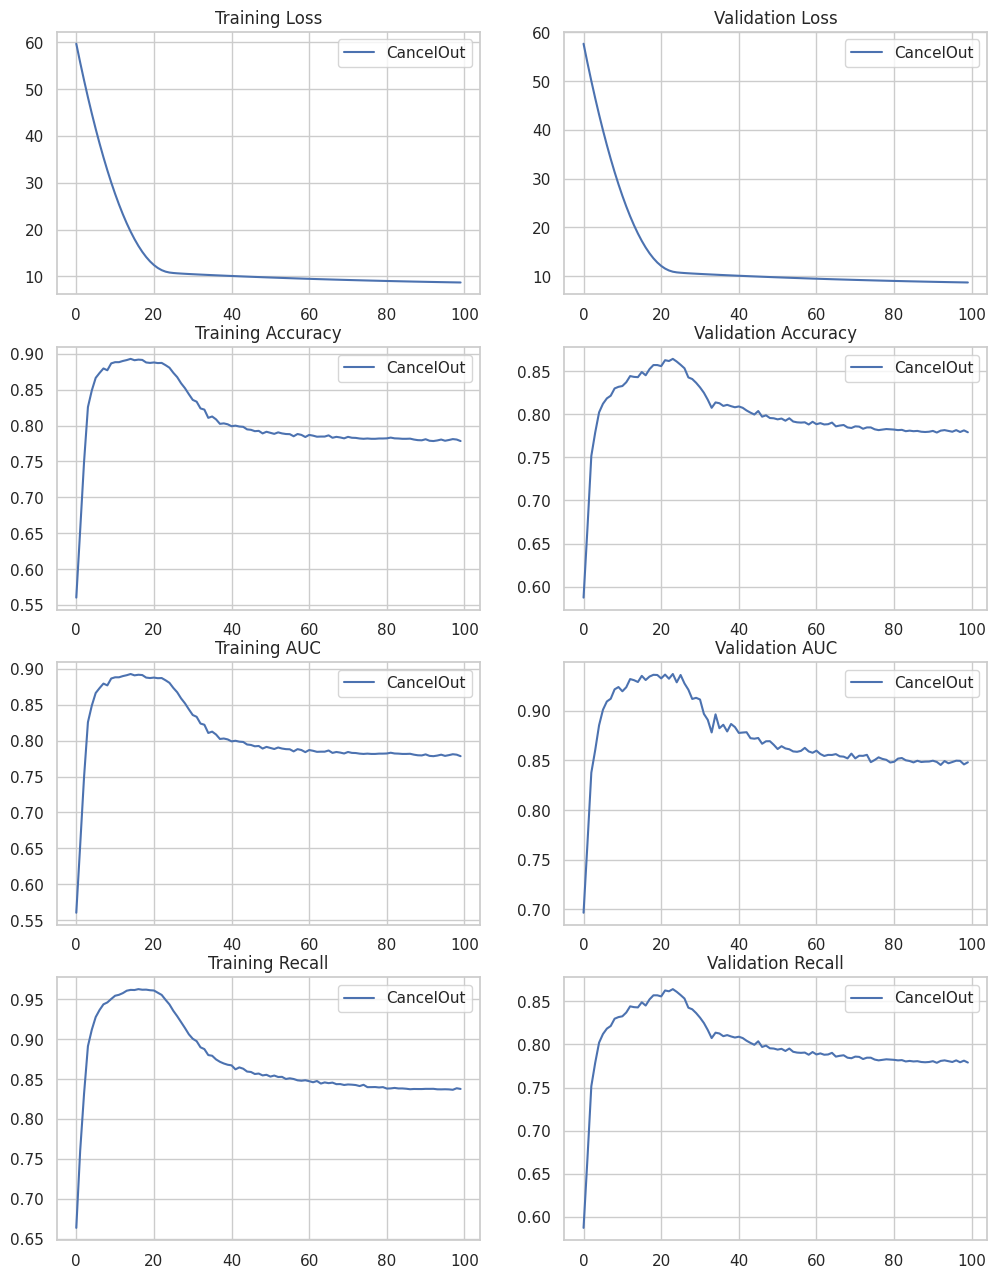

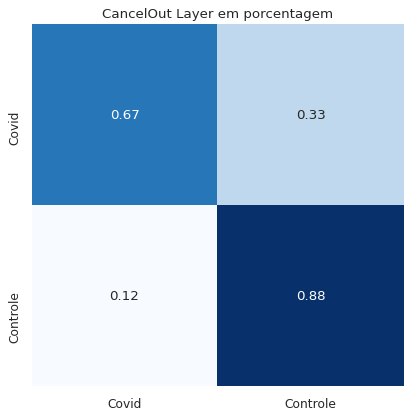

In [ ]:
cancelOut = {"CancelOut": pd.DataFrame.from_dict(history.history)}
plot_results(cancelOut)

y_pred = model.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test, y_pred, ['Covid', 'Controle'], 'CancelOut Layer em porcentagem')

In [ ]:
input_shape = (X_train.shape[1], ) # (3934, )

model = CovDenseNet_CancelOut(input_shape)

history = model.fit(
                    X_train_norm, y_train_categ, 
                    validation_data=(X_test_norm, y_test_categ), 
                    epochs=200
                    )

Epoch 1/200
150/150 [==============================] - 3s 12ms/step - loss: 60.6780 - binary_accuracy: 0.5463 - precision_14: 0.5463 - recall_14: 0.5463 - auc_14: 0.6314 - val_loss: 57.6392 - val_binary_accuracy: 0.5876 - val_precision_14: 0.5876 - val_recall_14: 0.5876 - val_auc_14: 0.6970
Epoch 2/200
150/150 [==============================] - 1s 8ms/step - loss: 56.6443 - binary_accuracy: 0.6141 - precision_14: 0.6141 - recall_14: 0.6141 - auc_14: 0.7432 - val_loss: 53.7455 - val_binary_accuracy: 0.6867 - val_precision_14: 0.6867 - val_recall_14: 0.6867 - val_auc_14: 0.7795
Epoch 3/200
150/150 [==============================] - 1s 8ms/step - loss: 52.7957 - binary_accuracy: 0.7553 - precision_14: 0.7553 - recall_14: 0.7553 - auc_14: 0.8331 - val_loss: 50.0261 - val_binary_accuracy: 0.7475 - val_precision_14: 0.7475 - val_recall_14: 0.7475 - val_auc_14: 0.8300
Epoch 4/200
150/150 [==============================] - 1s 8ms/step - loss: 49.1164 - binary_accuracy: 0.8103 - precision_14: 0

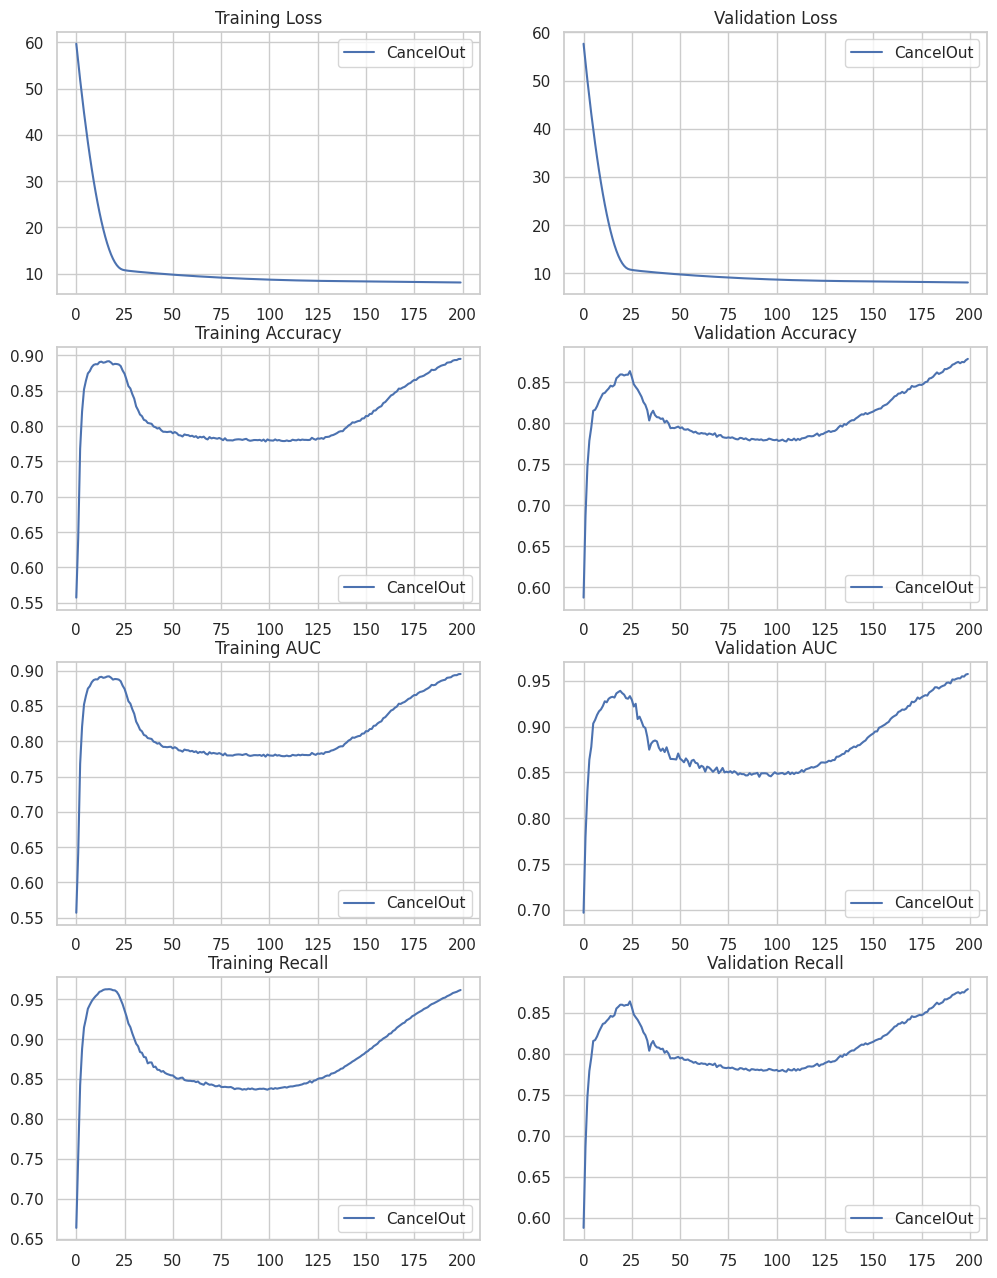

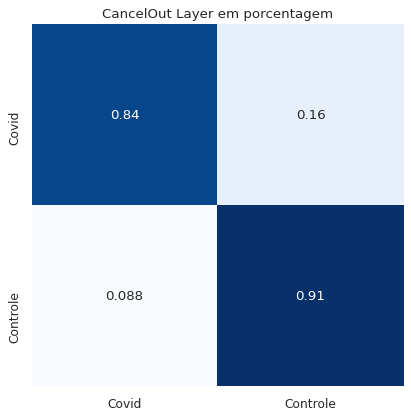

In [ ]:
cancelOut = {"CancelOut": pd.DataFrame.from_dict(history.history)}
plot_results(cancelOut)

y_pred = model.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test, y_pred, ['Covid', 'Controle'], 'CancelOut Layer em porcentagem')

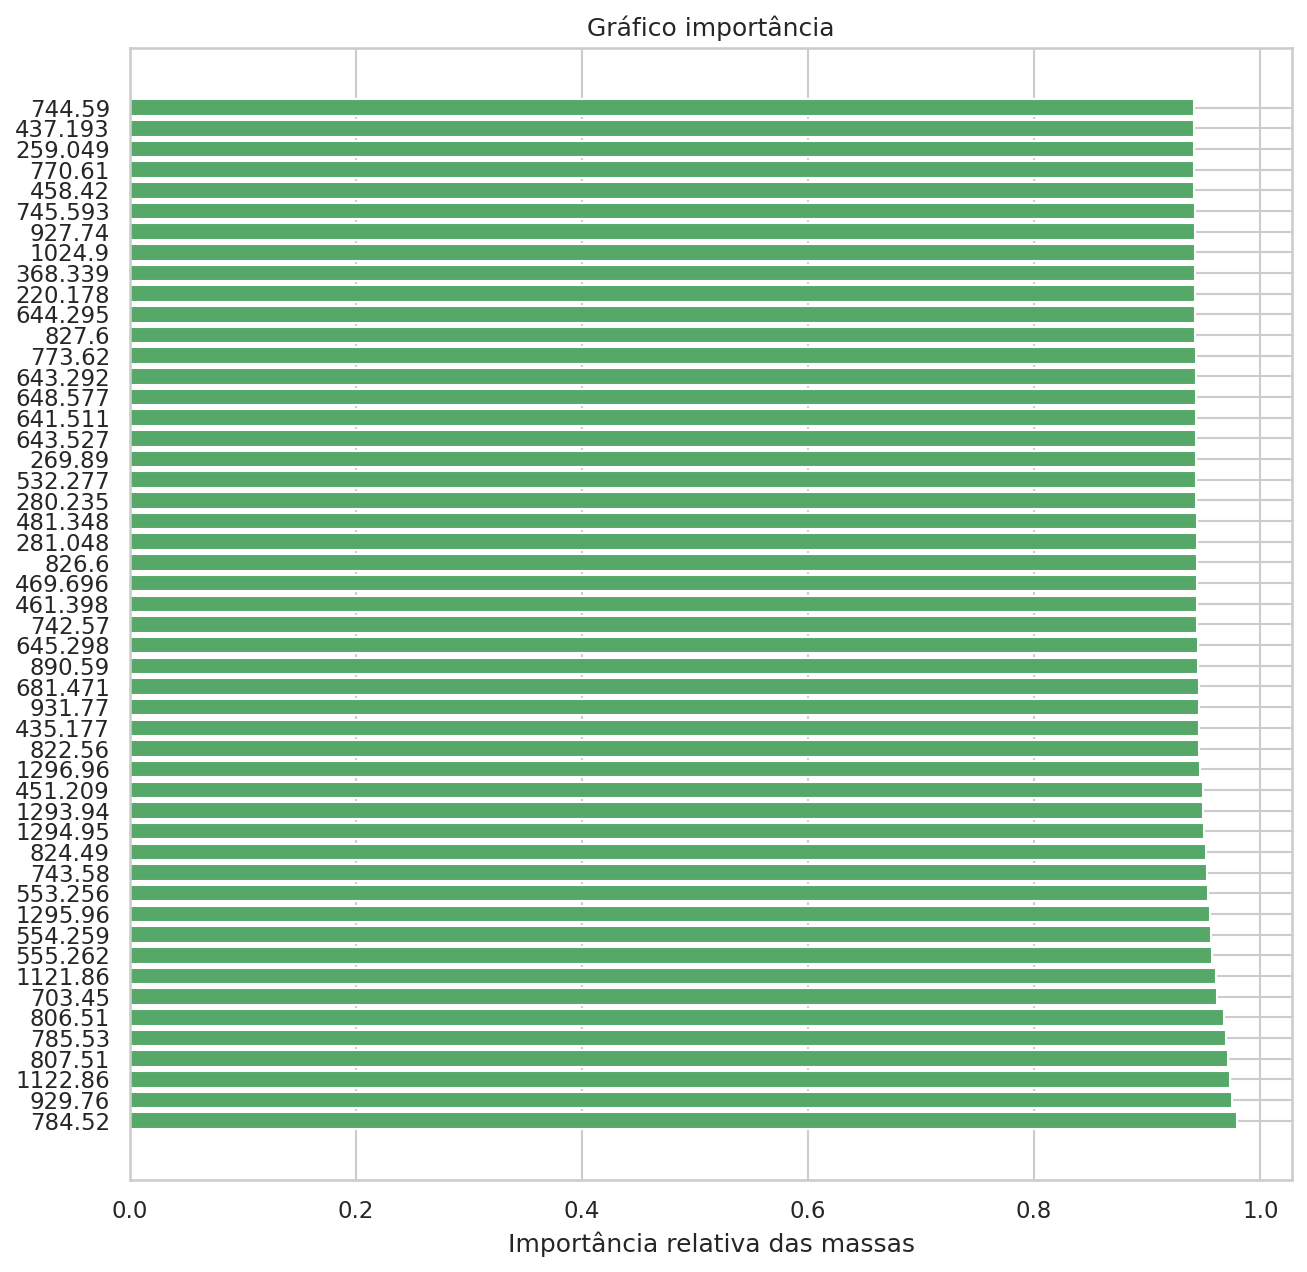

In [ ]:
importances = model.get_weights()[0]
args_n_most_impor = plot_importance(importances, 50, list(X_train))

# Feature analyses
---

In [ ]:
ROOT_FOLDER = 'drive/Shareddrives/MO434_final_project/Dataset/FINAL_DATASET/'

df_train = pd.read_pickle(ROOT_FOLDER + 'Train_FeatureVectors_Covid16_Classifier_Bag.pkl')
df_test = pd.read_pickle(ROOT_FOLDER + 'Test_FeatureVectors_Covid16_Classifier_Bag.pkl')

In [ ]:
train_CV_index = train[train['# class'] == '1'].index
X_train_CV = X_train_norm.loc[train_CV_index]
y_train_CV = to_categorical(y_train[y_train == 1], num_classes=len(np.unique(y_train) - 1))

input_shape = (X_train_CV.shape[1], )

model = CovDenseNet_CancelOut(input_shape)

history = model.fit(
                    X_train_CV, y_train_CV, 
                    epochs=500
                    )

cancelOut = {"CancelOut": pd.DataFrame.from_dict(history.history)}

importances_CV = model.get_weights()[0]
features = np.array(list(X_train_CV))
most_revelant_features_CV = np.flip(np.argsort(importances_CV))[:100]

Epoch 1/500
79/79 [==============================] - 3s 5ms/step - loss: 60.9548 - binary_accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000
Epoch 2/500
79/79 [==============================] - 0s 5ms/step - loss: 58.5862 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 3/500
79/79 [==============================] - 0s 5ms/step - loss: 56.4094 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/500
79/79 [==============================] - 0s 5ms/step - loss: 54.3303 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 5/500
79/79 [==============================] - 0s 5ms/step - loss: 52.3156 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 6/500
79/79 [==============================] - 0s 5ms/step - loss: 50.3602 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 7/500
79/79 [==============================] -

In [ ]:
train_CT_index = train[train['# class'] == '0'].index
X_train_CT = X_train_norm.loc[train_CT_index]
y_train_CT = to_categorical(y_train[y_train == 0], num_classes=len(np.unique(y_train) - 1))

input_shape = (X_train_CT.shape[1], )

model = CovDenseNet_CancelOut(input_shape)

history = model.fit(
                    X_train_CT, y_train_CT, 
                    epochs=500
                    )

cancelOut = {"CancelOut": pd.DataFrame.from_dict(history.history)}

importances_CT = model.get_weights()[0]
features = np.array(list(X_train_CT))
most_revelant_features_CT = np.flip(np.argsort(importances_CT))[:100]

Epoch 1/500
71/71 [==============================] - 1s 5ms/step - loss: 61.2369 - binary_accuracy: 0.4472 - precision_1: 0.4472 - recall_1: 0.4472 - auc_1: 0.4714
Epoch 2/500
71/71 [==============================] - 0s 5ms/step - loss: 59.0344 - binary_accuracy: 0.9962 - precision_1: 0.9962 - recall_1: 0.9962 - auc_1: 0.9999
Epoch 3/500
71/71 [==============================] - 0s 5ms/step - loss: 57.0241 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - auc_1: 1.0000
Epoch 4/500
71/71 [==============================] - 0s 5ms/step - loss: 55.1173 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - auc_1: 1.0000
Epoch 5/500
71/71 [==============================] - 0s 5ms/step - loss: 53.2653 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - auc_1: 1.0000
Epoch 6/500
71/71 [==============================] - 0s 5ms/step - loss: 51.4775 - binary_accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - auc_1: 1.0000
Epoch 7/500
71/7

In [ ]:
all_features = np.concatenate((most_revelant_features_CT, most_revelant_features_CV))

In [ ]:
X_train = X_train.iloc[:, all_features]
# y_train_seeds = to_categorical(y_train_seeds, 2)

X_train = X_train.apply(normalize_dataset_by_sample)

X_test = X_test.iloc[:, all_features]
X_test = X_test.apply(normalize_dataset_by_sample)

# Graph Convolutional Network (GCN)
---

Here we had implemented a graph based approach. To define the graph edges we compute the cosine distance one vs all sample and considering a threshold the connections was biulded.

In [10]:
ROOT_FOLDER = 'drive/Shareddrives/MO434_final_project/Dataset/FINAL_DATASET/'

df_train = pd.read_pickle(ROOT_FOLDER + 'Train_FeatureVectors_Covid16_Classifier_Bag.pkl')
train_edges = pd.read_csv(ROOT_FOLDER + 'train_egdes_pat.csv')

df_test = pd.read_pickle(ROOT_FOLDER + 'Test_FeatureVectors_Covid16_Classifier_Bag.pkl')
test_edges = pd.read_csv(ROOT_FOLDER + 'test_egdes_pat.csv')

In [11]:
X_train = df_train.iloc[:, 44:].astype(float)
X_train = X_train.apply(normalize_dataset_by_sample)
y_train = df_train['# class'].astype(int).to_numpy()

X_test = df_test.iloc[:, 44:].astype(float)
X_test = X_test.apply(normalize_dataset_by_sample)
y_test = df_test['# class'].astype(int).to_numpy()

num_classes = len(np.unique(list(df_test['# class'])))
num_node_features = X_test.shape[1]

In [12]:
train_u = np.concatenate([train_edges['Source'], train_edges['Target']])
train_v = np.concatenate([train_edges['Target'], train_edges['Source']])

train_G = dgl.DGLGraph((train_u, train_v))
train_G.ndata['feat'] = torch.FloatTensor(X_train.to_numpy())

test_u = np.concatenate([test_edges['Source'], test_edges['Target']])
test_v = np.concatenate([test_edges['Target'], test_edges['Source']])

test_G = dgl.DGLGraph((test_u, test_v))
test_G.ndata['feat'] = torch.FloatTensor(X_test.to_numpy())

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [13]:
class GCN(nn.Module):
  def __init__(self, in_feats, hidden_size, num_classes):
    super(GCN, self).__init__()
    self.conv1 = GraphConv(in_feats, hidden_size)
    self.conv2 = GraphConv(hidden_size, num_classes)

  def forward(self, g, inputs):
    h = self.conv1(g, inputs)
    h = torch.relu(h)
    h = F.dropout(h, training=self.training)
    h = self.conv2(g, h)

    return h

In [14]:
model = GCN(X_train.shape[1], 15, 2)

In [15]:
train_inputs = torch.FloatTensor(X_train.to_numpy())
train_labeled_nodes = torch.tensor(range(X_train.shape[0]))
train_labels = torch.tensor(y_train)

test_inputs = torch.FloatTensor(X_test.to_numpy())
test_labeled_nodes = torch.tensor(range(X_test.shape[0]))
test_labels = torch.tensor(y_test)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

all_logits = []
train_G = dgl.add_self_loop(train_G)
test_G = dgl.add_self_loop(test_G)

for epoch in range(101):

  model.train()
  logits = model(train_G, train_inputs)
  # we save the logits for visualization later
  all_logits.append(logits.detach())
  logp = F.log_softmax(logits, 1)

  # we only compute loss for labeled nodes
  loss = F.nll_loss(logp, train_labels)
  # loss_ = nn.CrossEntropyLoss()
  # loss = loss_(logp, labels)

  acc = m.accuracy_score(y_train, torch.max(logits, axis=1)[1])
  recall = m.recall_score(y_train, torch.max(logits, axis=1)[1], average='weighted')
  auc = m.roc_auc_score(y_train, torch.max(logits, axis=1)[1])

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  test_val_preds = model(test_G, test_inputs)
  test_acc = m.accuracy_score(y_test, torch.max(test_val_preds, axis=1)[1])
  test_recall = m.recall_score(y_test, torch.max(test_val_preds, axis=1)[1], average='weighted')
  test_auc = m.roc_auc_score(y_test, torch.max(test_val_preds, axis=1)[1])

  if epoch % 10 == 0:
        
    print('Epoch %d | Loss: %.4f | Acc: %.4f | Recall: %.4f | AUC: %.4f' % (epoch, loss.item(), acc, recall, auc))
    print('Test | Acc: %.4f | Recall: %.4f | AUC: %.4f' % (test_acc, test_recall, test_auc))



Epoch 0 | Loss: 0.7097 | Acc: 0.4708 | Recall: 0.4708 | AUC: 0.4976
Test | Acc: 0.5920 | Recall: 0.5920 | AUC: 0.5688
Epoch 10 | Loss: 0.6661 | Acc: 0.5932 | Recall: 0.5932 | AUC: 0.5707
Test | Acc: 0.5920 | Recall: 0.5920 | AUC: 0.5688
Epoch 20 | Loss: 0.6517 | Acc: 0.5907 | Recall: 0.5907 | AUC: 0.5687
Test | Acc: 0.5920 | Recall: 0.5920 | AUC: 0.5688
Epoch 30 | Loss: 0.6461 | Acc: 0.5907 | Recall: 0.5907 | AUC: 0.5687
Test | Acc: 0.5920 | Recall: 0.5920 | AUC: 0.5688
Epoch 40 | Loss: 0.6448 | Acc: 0.5907 | Recall: 0.5907 | AUC: 0.5682
Test | Acc: 0.5920 | Recall: 0.5920 | AUC: 0.5688
Epoch 50 | Loss: 0.6437 | Acc: 0.5917 | Recall: 0.5917 | AUC: 0.5697
Test | Acc: 0.5764 | Recall: 0.5764 | AUC: 0.5524
Epoch 60 | Loss: 0.6429 | Acc: 0.5907 | Recall: 0.5907 | AUC: 0.5682
Test | Acc: 0.5920 | Recall: 0.5920 | AUC: 0.5688
Epoch 70 | Loss: 0.6425 | Acc: 0.5909 | Recall: 0.5909 | AUC: 0.5690
Test | Acc: 0.5764 | Recall: 0.5764 | AUC: 0.5524
Epoch 80 | Loss: 0.6424 | Acc: 0.5909 | Recall: 0

# Multiclass classification
---

In [ ]:
# Primeiro um classificador covid - não covid
# Segundo um classificador covid grave - covid não grave

print((np.unique(train['# category'])))
print((np.unique(train['# ctg number'])))

['COV/IN/GV' 'COV/IN/GV/O' 'COV/MN/DA/GV' 'COV/MN/DA/GV/O' 'COV/MN/GV'
 'COV/MN/GV/O' 'COV/MN/NG' 'COV/SP/GV' 'COV/SP/NG' 'COV/ST1/MIXA'
 'COV/ST1/MIXB' 'COV/ST1/POS' 'CT/SP/NG' 'CTL/CH' 'CTL/DM' 'CTL/ED'
 'CTL/OB' 'CTL/SP/GV' 'CTL/ST1']
['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '3' '4' '5' '6'
 '7' '8' '9']


In [ ]:
X, y_train = to_multiclass(train['# ctg number'].astype(int))
X, y_test = to_multiclass(test['# ctg number'].astype(int))

y_train_categ = to_categorical(y_train, 3)
y_test_categ = to_categorical(y_test, 3)

input_shape = (X_train.shape[1], ) # (3934, )

model_2 = CovDenseNet(input_shape, 3)

history_2 = model_2.fit(X_train_norm, y_train_categ, validation_data=(X_test_norm, y_test_categ), epochs=EPOCHS)

Epoch 1/100
150/150 [==============================] - 3s 13ms/step - loss: 53.2254 - binary_accuracy: 0.6667 - precision_1: 0.5083 - recall_1: 0.0067 - auc_1: 0.6043 - val_loss: 50.1704 - val_binary_accuracy: 0.6676 - val_precision_1: 0.5692 - val_recall_1: 0.0115 - val_auc_1: 0.6541
Epoch 2/100
150/150 [==============================] - 1s 9ms/step - loss: 49.1701 - binary_accuracy: 0.6689 - precision_1: 0.9317 - recall_1: 0.0071 - auc_1: 0.7097 - val_loss: 46.2684 - val_binary_accuracy: 0.6719 - val_precision_1: 0.8906 - val_recall_1: 0.0178 - val_auc_1: 0.7146
Epoch 3/100
150/150 [==============================] - 1s 8ms/step - loss: 45.3120 - binary_accuracy: 0.6728 - precision_1: 0.9757 - recall_1: 0.0190 - auc_1: 0.7736 - val_loss: 42.5457 - val_binary_accuracy: 0.6772 - val_precision_1: 0.9391 - val_recall_1: 0.0337 - val_auc_1: 0.7560
Epoch 4/100
150/150 [==============================] - 1s 8ms/step - loss: 41.6352 - binary_accuracy: 0.6794 - precision_1: 0.9824 - recall_1: 0

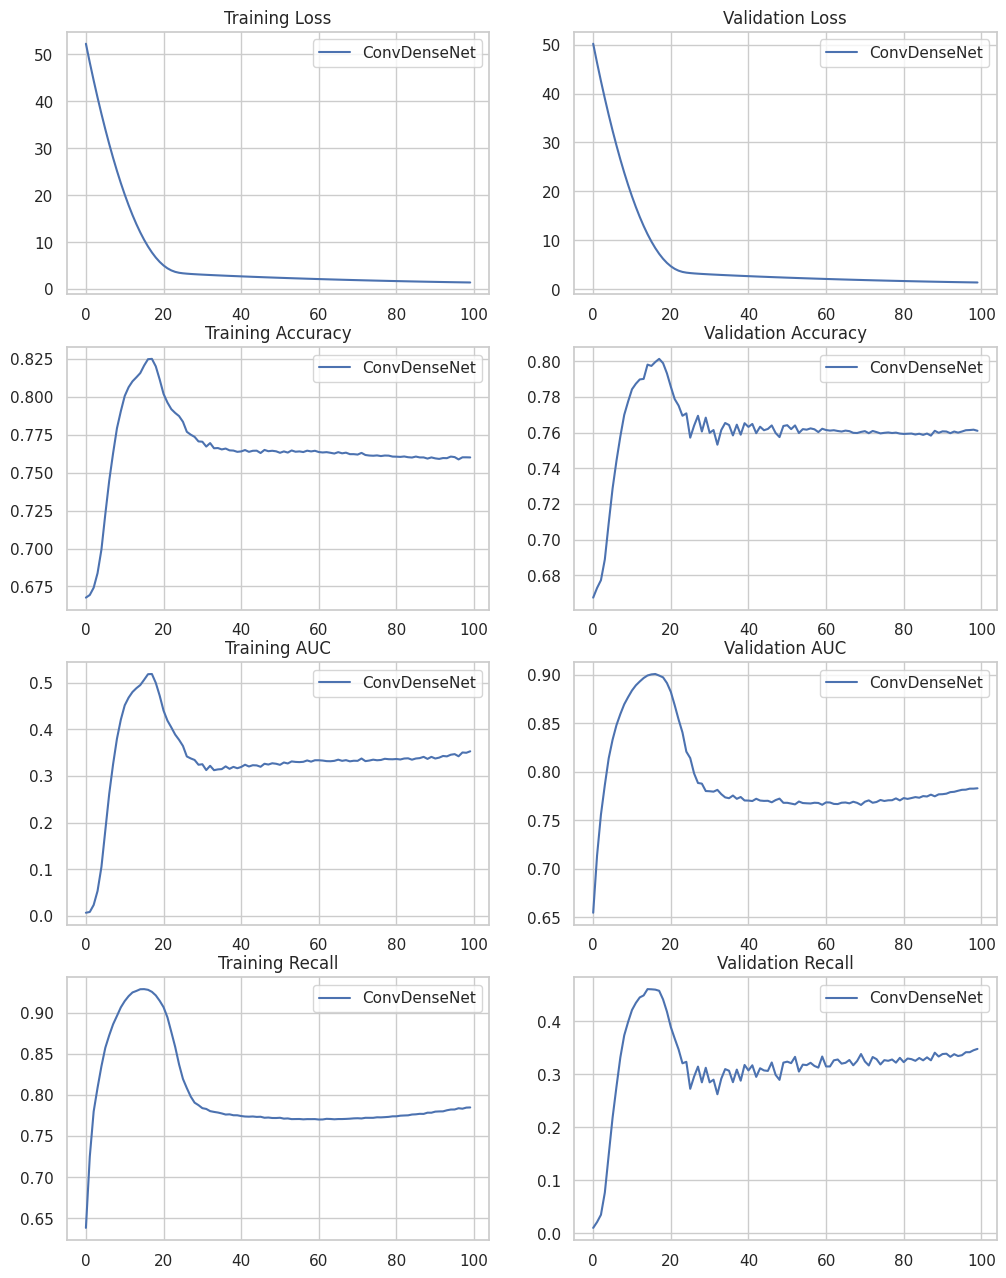

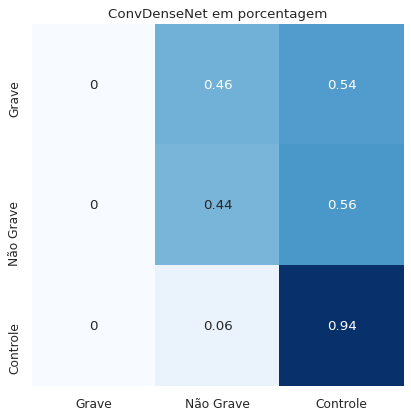

In [ ]:
conv_cov_net = {"ConvDenseNet": pd.DataFrame.from_dict(history_2.history)}
plot_results(conv_cov_net)

y_pred = model_2.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, ['Grave', 'Não Grave', 'Controle'], 'ConvDenseNet em porcentagem')

# Train the network for severity detection
---

Epoch 1/100
79/79 [==============================] - 2s 15ms/step - loss: 53.1741 - binary_accuracy: 0.6446 - precision_7: 0.6446 - recall_7: 0.6446 - auc_7: 0.7423 - val_loss: 51.5110 - val_binary_accuracy: 0.6952 - val_precision_7: 0.6952 - val_recall_7: 0.6952 - val_auc_7: 0.7885
Epoch 2/100
79/79 [==============================] - 1s 8ms/step - loss: 50.9634 - binary_accuracy: 0.6800 - precision_7: 0.6800 - recall_7: 0.6800 - auc_7: 0.8181 - val_loss: 49.3771 - val_binary_accuracy: 0.7413 - val_precision_7: 0.7413 - val_recall_7: 0.7413 - val_auc_7: 0.8210
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 48.8162 - binary_accuracy: 0.7731 - precision_7: 0.7731 - recall_7: 0.7731 - auc_7: 0.8766 - val_loss: 47.2984 - val_binary_accuracy: 0.7527 - val_precision_7: 0.7527 - val_recall_7: 0.7527 - val_auc_7: 0.8387
Epoch 4/100
79/79 [==============================] - 1s 8ms/step - loss: 46.7461 - binary_accuracy: 0.8072 - precision_7: 0.8072 - recall_7: 0.8072 - 

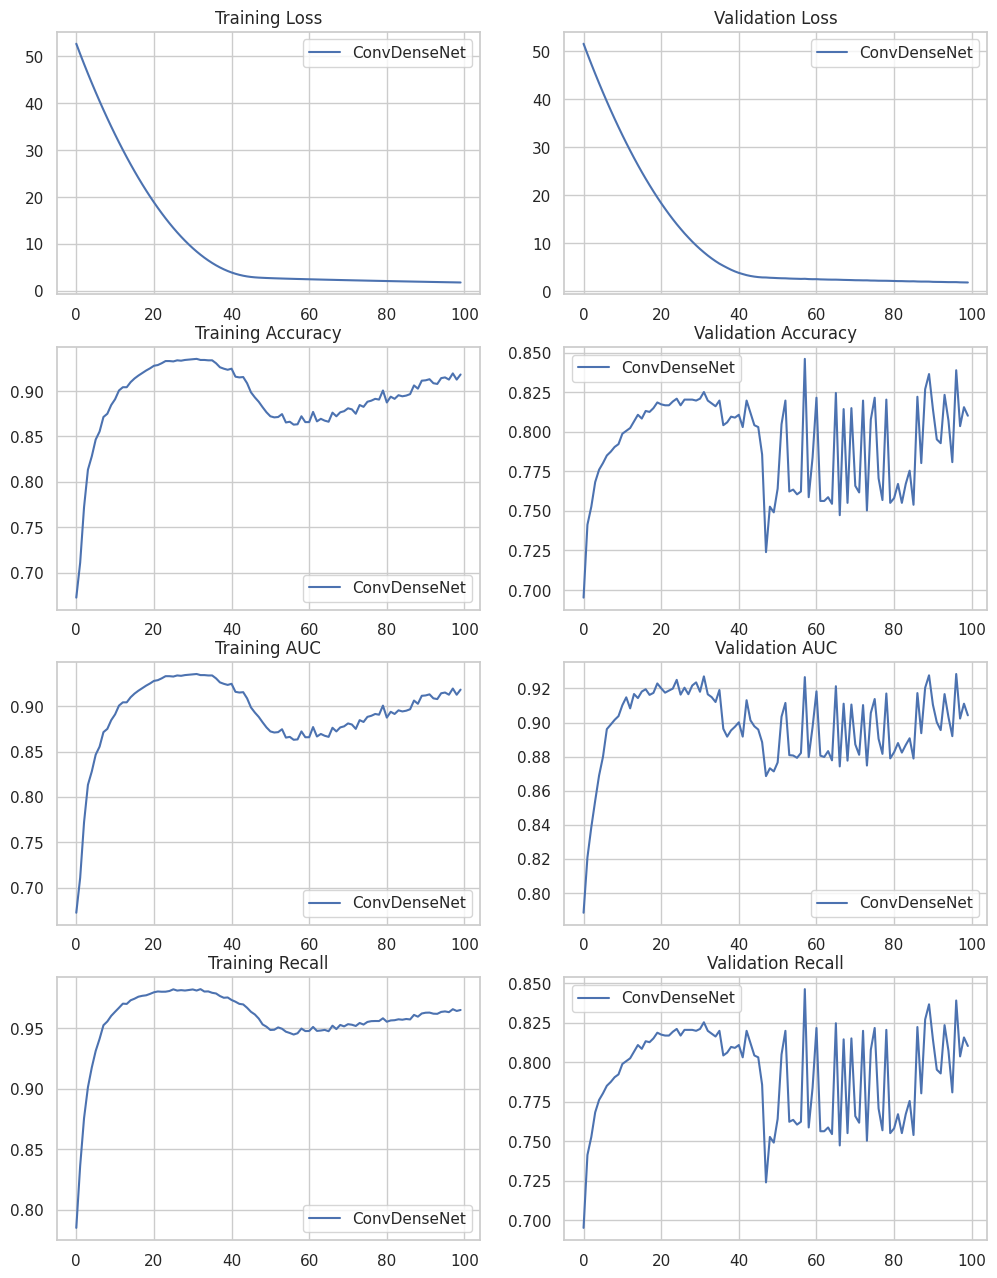

In [ ]:
X_train_norm, y_train = to_multiclass(train['# ctg number'].astype(int), X=train.iloc[:, 44:].astype(float), drop=True)
X_test_norm, y_test = to_multiclass(test['# ctg number'].astype(int), X=test.iloc[:, 44:].astype(float), drop=True)

y_train_categ = to_categorical(y_train, 2)
y_test_categ = to_categorical(y_test, 2)

X_train_norm = X_train_norm.apply(normalize_dataset_by_sample)
X_test_norm = X_test_norm.apply(normalize_dataset_by_sample)

input_shape = (X_train_norm.shape[1], )

model_2 = CovDenseNet(input_shape, 2)

history_2 = model_2.fit(X_train_norm, y_train_categ, validation_data=(X_test_norm, y_test_categ), epochs=EPOCHS)
# model_2.save('drive/Shareddrives/MO434_final_project/Models/CovDenseNet_gravi')

conv_cov_net = {"ConvDenseNet": pd.DataFrame.from_dict(history_2.history)}
plot_results(conv_cov_net)



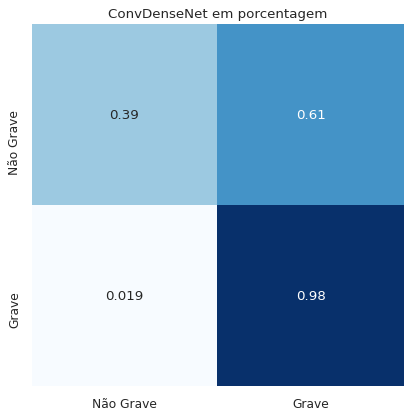

In [ ]:
y_pred = model_2.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, ['Não Grave', 'Grave'], 'ConvDenseNet em porcentagem')

#Blind Test
---

In [4]:
blind_test = pd.read_pickle('drive/Shareddrives/MO434_final_project/Dataset/FINAL_DATASET/Blind_FeatureVectors_Covid16_Classifier_Bag.pkl')
# X_train_norm, y_train = to_multiclass(train['# ctg number'].astype(int), X=train.iloc[:, 44:].astype(float), drop=True)
# X_val_norm, y_val = to_multiclass(test['# ctg number'].astype(int), X=test.iloc[:, 44:].astype(float), drop=True)
# X_test_norm, y_test = to_multiclass(test_dataset['# ctg number'].astype(int), X=test_dataset.iloc[:, 44:].astype(float), drop=True)
# y_train_categ = to_categorical(y_train, 2)
# y_val_categ = to_categorical(y_val, 2)
# y_test_categ = to_categorical(y_test, 2)

# X_train_norm = X_train_norm.apply(normalize_dataset_by_sample)
# X_val_norm = X_val_norm.apply(normalize_dataset_by_sample)

In [ ]:
np.unique(blind_test['# ctg number'])

array(['1', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8',
       '9'], dtype=object)

In [ ]:
def final_model(test):

  X = test.iloc[:, 44:].astype(float)
  y_ctg = test['# ctg number'].astype(int)
  y_cls = test['# class'].astype(int)

  cov_model = keras.models.load_model('drive/Shareddrives/MO434_final_project/Models/CovDenseNet')
  cov_preds = cov_model.predict(X).argmax(axis=1)

  acc_cov = m.accuracy_score(y_cls, cov_preds)
  rll_cov = m.recall_score(y_cls, cov_preds)
  auc_cov = m.roc_auc_score(y_cls, cov_preds)

  X_test, y_test = to_multiclass(y_ctg, X=X, drop=True)
  y_test = np.argmax(y_test, axis=1)

  grav_model = keras.models.load_model('drive/Shareddrives/MO434_final_project/Models/CovDenseNet_gravi')
  grav_preds = grav_model.predict(X_test).argmax(axis=1)
  
  acc_gav = m.accuracy_score(y_test, grav_preds)
  rll_gav = m.recall_score(y_test, grav_preds)
  auc_gav = m.roc_auc_score(y_test, grav_preds)

  print('Diagnóstico COVID: Acc: {:.2f}, Recall: {:.2f}, AUC: {:.2f}'.format(acc_cov, rll_cov, auc_cov))

  print('Diagnóstico Severidade: Acc: {:.2f}, Recall: {:.2f}, AUC: {:.2f}'.format(acc_gav, rll_gav, auc_gav))

  # plot_confusion_matrix(y_cls, cov_preds, ['Covid', 'Controle'], 'ConvDenseNet em porcentagem')
  # plot_confusion_matrix(y_test, grav_preds, ['Não Grave', 'Grave'], 'ConvDenseNet em porcentagem')


In [ ]:
final_model(blind_test)

Diagnóstico COVID: Acc: 0.86, Recall: 1.00, AUC: 0.59
Diagnóstico Severidade: Acc: 0.41, Recall: 1.00, AUC: 0.50


In [14]:
ctl, cv = np.unique(blind_test['# class'].astype(int), return_counts=True)[1]

print('Conjunto de teste altamente desbalanceado. Contém {} amostras de controle contra {} amostras de COVID.'.format(ctl, cv))

Conjunto de teste altamente desbalanceado. Contém 500 amostras de controle contra 2309 amostras de COVID.
